In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transaction.csv')

# Explore datasets
print(customers.info())
print(products.info())
print(transactions.info())

# Convert dates
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Example insights
# Top-selling products
top_products = merged_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False)

# Regional trends
region_sales = merged_data.groupby('Region')['TotalValue'].sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

<ipython-input-7-9cacee275700>:18: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np

# Feature engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'TransactionCount'})

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features)

# Compute similarity
similarity_matrix = cosine_similarity(normalized_features)

# Recommendations
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features.index, columns=customer_features.index)
def get_top_n_similar(customers, n=3):
    recommendations = {}
    for customer in customers:
        similar_customers = similarity_df[customer].sort_values(ascending=False).iloc[1:n+1]
        recommendations[customer] = list(similar_customers.index)
    return recommendations

# Generate recommendations for first 20 customers
lookalikes = get_top_n_similar(customer_features.index[:20])
lookalikes_df = pd.DataFrame.from_dict(lookalikes, orient='index', columns=[f'Similar_{i+1}' for i in range(3)])
lookalikes_df.to_csv('FirstName_LastName_Lookalike.csv', index_label='CustomerID')

Davies-Bouldin Index: 0.5164288374293444


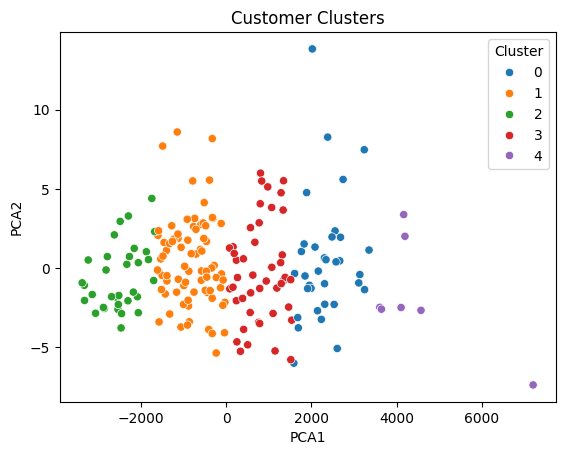

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Prepare clustering data
clustering_data = customer_features

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(clustering_data)

# Assign clusters
clustering_data['Cluster'] = kmeans.labels_

# Calculate DB Index
db_index = davies_bouldin_score(clustering_data.drop('Cluster', axis=1), clustering_data['Cluster'])
print('Davies-Bouldin Index:', db_index)

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_data.drop('Cluster', axis=1))
clustering_data['PCA1'] = reduced_data[:, 0]
clustering_data['PCA2'] = reduced_data[:, 1]

sns.scatterplot(data=clustering_data, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('Customer Clusters')
plt.show()